TODO:
- Find two proper time series, one start and one target TS
- Calculate features target TS. These are the target features.
- Use GA to find feature factors that minimize the distance between the feature values of modified start TS and target features.
  - The fitness function in PyGAD is maximized. Intead of minimizing the distance, maximize the negative distance.
  - Use Euclidean distance
- Plot results

In [64]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import sys

## Load data

In [65]:


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

if src_path not in sys.path:
    sys.path.append(src_path)
    
from utils.generate_dataset import generate_windows_dataset
from utils.features import decomp_and_features


data_dir_path = os.path.join("..", "data", "gridloss", "train.csv")
df = pd.read_csv(data_dir_path, index_col=0)
df.index = pd.to_datetime(df.index)

# Backfill missing data
df = df.bfill()

grid1_columns = ["grid1-load","grid1-loss","grid1-temp"]
window_size = 168 # 1 week
step_size = 24
num_ts = len(grid1_columns)
dataset_size = (df.shape[0] - window_size)//step_size + 1
force_calc_windows: bool = True

windows_data_paths = [os.path.join("..", "data", "gridloss", "windows", f"ts{i}_w{window_size}_s{step_size}_n{dataset_size}.csv") for i in range(num_ts)]
load_windows: bool = all([os.path.exists(path) for path in windows_data_paths])

if not load_windows or force_calc_windows:
    print("Generating windows dataset")
    data = generate_windows_dataset(df, window_size, step_size, grid1_columns)
else:
    # TODO: Add datetime index to the windows that are saved/loaded
    print("Loading windows dataset")
    data_transposed = [pd.read_csv(path).to_numpy() for path in windows_data_paths]
    data = np.asarray(data_transposed).transpose(1, 2, 0).tolist()
    data = [pd.DataFrame(data[i], columns=grid1_columns) for i in range(len(data))]

Generating windows dataset


100%|██████████| 724/724 [00:00<00:00, 36878.38it/s]


## Features

In [66]:
from utils.features import decomp_and_features

sp = 24 # STL parameter

features_paths = [os.path.join("..", "data", "gridloss", "features", f"features_ts{i}_w{window_size}_s{step_size}_n{dataset_size}.csv") for i in range(num_ts)]
load_features = all([os.path.exists(path) for path in features_paths])

# NOTE: Currently not using, saving or loading decompositions
if not load_features:
    # Calculate features
    decomps, features = decomp_and_features(data, series_periodicity=sp, dataset_size=dataset_size)
    print(np.asarray(decomps).shape, features.shape)
else:
    # Load features from file
    features_transposed = [pd.read_csv(path).to_numpy() for path in features_paths]
    features = np.asarray(features_transposed).transpose(1, 0, 2)
    print(features.shape)

100%|██████████| 724/724 [00:13<00:00, 52.45it/s]

(724, 3) (724, 3, 4)


## PCA

In [67]:
from sklearn.decomposition import PCA
mts_features_reshape = features.reshape((features.shape[0], features.shape[1]*features.shape[2]))

pca_2d = PCA(n_components=2)
mts_pca_2d = pca_2d.fit_transform(mts_features_reshape)

mts_pca_df = pd.DataFrame(data=mts_pca_2d, columns=["pca1", "pca2"])
mts_pca_df['index'] = mts_pca_df.index

In [68]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [69]:
fig = px.scatter(mts_pca_df, x='pca1', y='pca2', hover_data=['index'])
fig.show()

## Time Series

In [70]:
start_ts_index = 636
target_ts_index = 105

# Start by only looking at the grid load time series, i.e. index 0
univariate_ts_index = 0


In [71]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Line(x=data[start_ts_index].index, y=data[start_ts_index]["grid1-load"], name="start"), row=1, col=1)
fig.add_trace(go.Line(x=data[target_ts_index].index, y=data[target_ts_index]["grid1-load"], name="target"), row=2, col=1)

fig.update_layout(height=600, width=800, title_text=f"{start_ts_index=} vs. {target_ts_index=}")

fig.show()

c:\Users\hansj\anaconda3\envs\BEAST_ENV\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [72]:
features_start = features[start_ts_index][univariate_ts_index]
features_target = features[target_ts_index][univariate_ts_index]

print("Start features:", features_start, "\nTarget features:", features_target)

Start features: [0.91638024 0.00142513 0.44456703 0.94553412] 
Target features: [ 0.82107228 -0.00096526  0.82971972  0.92247374]


## Genetic Algorithm

TODO: Create python class in utils for this

In [73]:
from utils.transformations import manipulate_trend_component, manipulate_seasonal_component
from utils.features import trend_strength, trend_slope, trend_linearity, seasonal_strength

In [74]:
decomp_start = decomps[start_ts_index][univariate_ts_index]

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def fitness_function(ga_instance, solution, solution_idx):
    # NOTE: Assuming solution is a list of feature modification factors [f, g, h, k]
    # TODO: Exclude m from solution for now. Seems to be causing issues
    solution_f = solution[0]
    solution_g = solution[1]
    solution_h = solution[2]
    solution_k = solution[3]
    
    solution_trend = manipulate_trend_component(decomp_start.trend, solution_f, solution_g, solution_h, m=0)
    solution_seasonal = manipulate_seasonal_component(decomp_start.seasonal, solution_k)
    
    solution_trend_strength = trend_strength(solution_trend, decomp_start.resid)
    solution_trend_slope = trend_slope(solution_trend)
    solution_trend_linearity = trend_linearity(solution_trend)
    solution_seasonal_strength = seasonal_strength(solution_seasonal, decomp_start.resid)
    
    features_solution = [solution_trend_strength, solution_trend_slope, solution_trend_linearity, solution_seasonal_strength]
    
    return -1 * euclidean_distance(np.array(features_solution), np.array(features_target))
    # return features_solution

In [75]:
import pygad

In [76]:
num_generations = 50
num_parents_mating = 1

fitness_function = fitness_function

sol_per_pop = 10
num_genes = 4 # f, g, h, k

init_range_low = -5
init_range_high = 5

# Parameters from pygad docs example
parent_selection_type = "sss"
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 25

ga_insatnce = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

In [77]:
ga_insatnce.run()

c:\Users\hansj\anaconda3\envs\BEAST_ENV\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



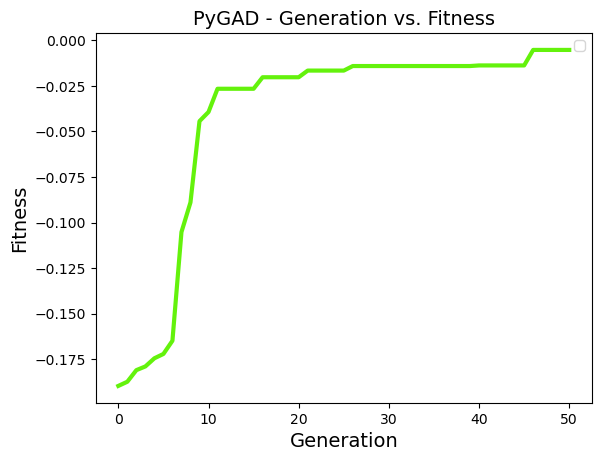

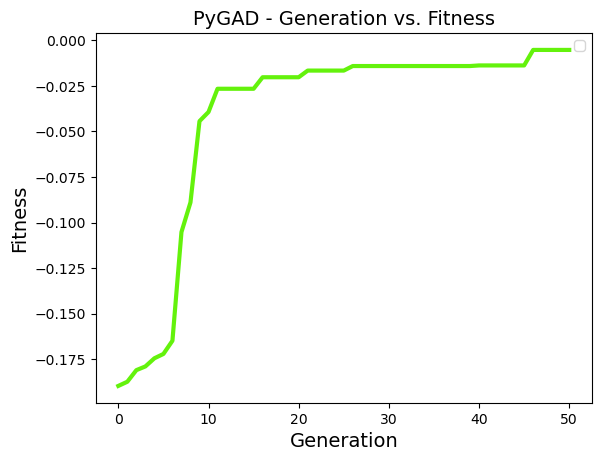

In [78]:
ga_insatnce.plot_fitness()

Clearly something is not right here...

In [79]:
solution, solution_fitness, solution_idx = ga_insatnce.best_solution()
print("Solution: ", solution)
print("Solution fitness: ", solution_fitness)
print("Solution index: ", solution_idx)

Solution:  [-0.35147478 -2.74882335  0.89283151 -0.81951568]
Solution fitness:  -0.005219934442704545
Solution index:  0


In [80]:
solution_f = solution[0]
solution_g = solution[1]
solution_h = solution[2]
solution_k = solution[3]

solution_trend = manipulate_trend_component(decomp_start.trend, solution_f, solution_g, solution_h, m=0)
solution_seasonal = manipulate_seasonal_component(decomp_start.seasonal, solution_k)
solution_ts = solution_trend + solution_seasonal + decomp_start.resid

In [81]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Line(x=data[start_ts_index].index, y=data[start_ts_index]["grid1-load"], name="start"), row=1, col=1)
fig.add_trace(go.Line(x=solution_ts.index, y=solution_ts, name="modified"), row=2, col=1)
fig.add_trace(go.Line(x=data[target_ts_index].index, y=data[target_ts_index]["grid1-load"], name="target"), row=3, col=1)

fig.update_layout(height=600, width=800, title_text=f"Start vs. Modified vs. Target")

fig.show()

c:\Users\hansj\anaconda3\envs\BEAST_ENV\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [82]:
solution_features = [
    trend_strength(solution_trend, decomp_start.resid),
    trend_slope(solution_trend),
    trend_linearity(solution_trend),
    seasonal_strength(solution_seasonal, decomp_start.resid)
]

print("Trend strength:", solution_features[0])
print("Trend slope:", solution_features[1])
print("Trend linearity:", solution_features[2])
print("Seasonal strength:", solution_features[3])

Trend strength: 0.8252683194044186
Trend slope: 0.0013824490012913717
Trend linearity: 0.8282085850605286
Seasonal strength: 0.9238323008403075


In [83]:
univariate_pca = PCA(n_components=2)
uts_features = mts_features_reshape[:, 0:4]
uts_pca = univariate_pca.fit_transform(uts_features)
solution_features_pca = univariate_pca.transform(np.array([solution_features]))


In [84]:
# Plotting the PCA of the features

fig = px.scatter(x=uts_pca[:, 0], y=uts_pca[:, 1], hover_data=[mts_pca_df['index']])
fig.add_trace(go.Scatter(x=solution_features_pca[:, 0], y=solution_features_pca[:, 1], mode='markers', marker=dict(size=10, color='red'), name="Solution"))
fig.add_trace(go.Scatter(x=[uts_pca[target_ts_index][0]], y=[uts_pca[target_ts_index][1]], mode='markers', marker=dict(size=10, color='green'), name="Target"))
fig.update_layout(
    xaxis_title="PC1",  # Custom X-axis label
    yaxis_title="PC2",  # Custom Y-axis label
    showlegend=True
)
fig.show()